In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
import os
os.getcwd()


'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody/ipynb'

In [3]:
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [19]:
# Load your tidy_524.csv or other
df = pd.read_csv("data/tidy_524.csv")

# Pick one antibody per row: pivot to wide form
df_wide = df.pivot(index="Accession", columns="Property", values="Value").dropna()

# Only numeric features now
X = df_wide.values

# Scale per feature (Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Reshape to (samples, height, width, channels)
X_train_reshaped = X_train.reshape((-1, 2, 2, 1))
X_test_reshaped  = X_test.reshape((-1, 2, 2, 1))


In [20]:
input_layer = layers.Input(shape=(2, 2, 1))

# Encoder
x = layers.Conv2D(8, (2, 2), activation='relu', padding='same')(input_layer)
x = layers.Flatten()(x)
encoded = layers.Dense(2, activation='relu')(x)

# Decoder
x = layers.Dense(4, activation='relu')(encoded)
x = layers.Reshape((2, 2, 1))(x)
decoded = layers.Conv2DTranspose(1, (2, 2), activation='linear', padding='same')(x)

# Build model
autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2, 2, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 8)        │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 2, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 2, 2, 1)        │             5 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123 (492.00 B)

 Trainable params: 123 (492.00 B)

 Non-trainable params: 0 (0.00 B)

OK lets reshape our data in an image like manner antibody x patient


In [21]:
history = autoencoder.fit(
    X_train_reshaped, X_train_reshaped,
    epochs=100,
    batch_size=8,
    shuffle=True,
    validation_data=(X_test_reshaped, X_test_reshaped),
    verbose=1
)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9010 - val_loss: 1.2748
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8950 - val_loss: 1.2625
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8884 - val_loss: 1.2473
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8783 - val_loss: 1.2300
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8676 - val_loss: 1.2133
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8580 - val_loss: 1.1991
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8488 - val_loss: 1.1875
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8429 - val_loss: 1.1780
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8389 - val_loss: 1.1686
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8364 - val_loss: 1.1608
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8335 - val_loss: 1.1562
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8319 - val_loss: 1.1510


In [22]:
# Reconstruct test set
reconstructed = autoencoder.predict(X_test_reshaped)

# Compute MSE per sample
X_test_flat = X_test_reshaped.reshape((X_test_reshaped.shape[0], -1))
reconstructed_flat = reconstructed.reshape((reconstructed.shape[0], -1))
mse = mean_squared_error(X_test_flat, reconstructed_flat)
print(f"Test MSE: {mse:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Test MSE: 0.7397


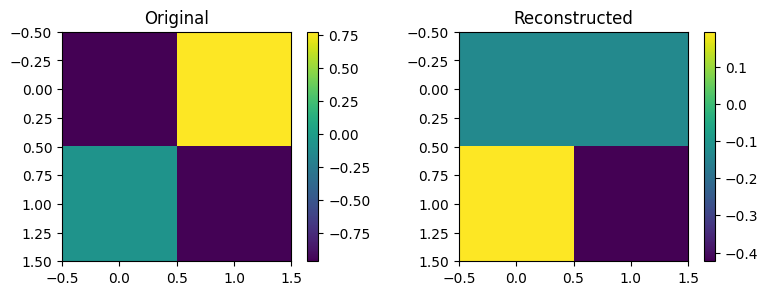

In [23]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(X_test_reshaped[0].squeeze(), cmap='viridis')
plt.title("Original")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(reconstructed[0].squeeze(), cmap='viridis')
plt.title("Reconstructed")
plt.colorbar()

plt.tight_layout()
plt.show()


**ImmPort 797**

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os

# === 1. Load your data ===
df = pd.read_csv("data/tidy_797.csv")

# Filter to GAD65, IA_2ic, MIAA, Zn_T8, ICA — adjust if needed
antibodies = ["GAD65", "IA_2ic", "MIAA", "Zn_T8", "ICA"]
df = df[df["Property"].isin(antibodies)]

# Pivot to wide format
df_wide = df.pivot(index="Accession", columns="Property", values="Value").fillna(0)

print("Wide shape:", df_wide.shape)  # should be (47, 5)

# === 2. Normalize (z-score column-wise) ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_wide.values)

# === 3. Reshape for CNN ===
# CNN expects 4D input: (samples, height, width, channels)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 5, 1, 1))  # shape: (47, 5, 1, 1)

# === 4. Train/test split ===
X_train, X_test = train_test_split(X_reshaped, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# === 5. Define CNN Autoencoder ===
input_shape = (5, 1, 1)
input_layer = layers.Input(shape=input_shape)

# Encoder
x = layers.Conv2D(8, (2, 1), activation='relu', padding='same')(input_layer)
x = layers.Flatten()(x)
encoded = layers.Dense(4, activation='relu')(x)

# Decoder
x = layers.Dense(8, activation='relu')(encoded)
x = layers.Dense(5, activation='linear')(x)
decoded = layers.Reshape((5, 1, 1))(x)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

# === 6. Train the model ===
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=8,
    shuffle=True,
    validation_data=(X_test, X_test),
    verbose=1
)

# === 7. Evaluate ===
train_mse = autoencoder.evaluate(X_train, X_train)
test_mse = autoencoder.evaluate(X_test, X_test)
print(f"\nTrain MSE: {train_mse:.4f}")
print(f"Test MSE:  {test_mse:.4f}")

# === 8. Save model ===

# Save model and weights directly to current directory
autoencoder.save("sdy797_autoencoder.keras")
autoencoder.save_weights("sdy797.weights.h5`")

# === 9. Plot training loss ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# === 10. Optional: Visualize reconstruction ===
reconstructed = autoencoder.predict(X_test)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(X_test[0].squeeze(), cmap='viridis')
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed[0].squeeze(), cmap='viridis')
plt.title("Reconstructed")
plt.show()


Wide shape: (49, 5)
Train shape: (39, 5, 1, 1)
Test shape: (10, 5, 1, 1)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 5, 1, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 1, 8)        │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │           164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 5, 1, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273 (1.07 KB)

 Trainable params: 273 (1.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9999 - val_loss: 1.1428
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9810 - val_loss: 1.1285
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9636 - val_loss: 1.1151
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9482 - val_loss: 1.1034
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9333 - val_loss: 1.0931
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9221 - val_loss: 1.0843
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9124 - val_loss: 1.0766
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9043 - val_loss: 1.0690
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8967 - val_loss: 1.0610
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8885 - val_loss: 1.0536
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8803 - val_loss: 1.0464
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8716 - val_loss: 1.0390


ValueError: The filename must end in `.weights.h5`. Received: filepath=sdy797.weights.h5`

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5, 1, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 1, 8)        │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 4, 1, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 4, 1, 1)        │             5 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233 (932.00 B)

 Trainable params: 233 (932.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


ValueError: Dimensions must be equal, but are 5 and 4 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, functional_4_1/conv2d_transpose_2_1/Add)' with input shapes: [?,5,1,1], [?,4,1,1].

In [ ]:
import os
import pandas as pd
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

# Load tidy file
df = pd.read_csv("data/tidy_797.csv")

# Only keep relevant columns
df = df[["Accession", "Property", "Value"]]

# Pivot to get patients × antibodies matrix
df_wide = df.pivot_table(index="Accession", columns="Property", values="Value")

# Fill missing values with 0 or other strategy
df_wide = df_wide.fillna(0)

# Check shape
print(df_wide.shape)


In [ ]:
import numpy as np

X = df_wide.values

# Example: reshape to (n_samples, height, width, channels)
# Let's treat this as a 2x2 image (if 4 antibodies)
X_reshaped = X.reshape((X.shape[0], 1, 5, 1))

In [ ]:
from tensorflow.keras import layers, models

input_shape = X_reshaped.shape[1:]  # e.g., (2, 2, 1)
input_layer = layers.Input(shape=input_shape)

# Encoder
x = layers.Conv2D(8, (2, 2), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((1, 1), padding='same')(x)
encoded = layers.Conv2D(4, (1, 1), activation='relu', padding='same')(x)

# Decoder
x = layers.Conv2D(4, (1, 1), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((1, 1))(x)
decoded = layers.Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


In [ ]:
autoencoder.fit(X_reshaped, X_reshaped, epochs=50, batch_size=8, shuffle=True)


In [ ]:
# 1. Reconstruct using the trained autoencoder
reconstructed = autoencoder.predict(X_reshaped)

# 2. Import plotting tools
import matplotlib.pyplot as plt

# 3. Extract one sample from original and reconstructed, reshape to 2D
# Assumes X_reshaped shape is (n_samples, height, width, channels), e.g., (49, 5, 1, 1)
original_sample = X_reshaped[0, :, :, 0]         # Shape (5, 1)
reconstructed_sample = reconstructed[0, :, :, 0] # Shape (5, 1)

# 4. Plot original
plt.imshow(original_sample, cmap='viridis', aspect='auto')
plt.title("Original Input")
plt.colorbar()
plt.show()

# 5. Plot reconstructed
plt.imshow(reconstructed_sample, cmap='viridis', aspect='auto')
plt.title("Reconstructed Output")
plt.colorbar()
plt.show()


In [ ]:
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

In [ ]:
import pandas as pd

# Load tidy file
df = pd.read_csv("data/tidy_1737.csv")

# Only keep relevant columns
df = df[["Accession", "Property", "Value"]]

# Pivot to get patients × antibodies matrix
df_wide = df.pivot_table(index="Accession", columns="Property", values="Value")

# Fill missing values with 0 or other strategy
df_wide = df_wide.fillna(0)

# Check shape
print(df_wide.shape)

In [ ]:
import numpy as np

X = df_wide.values

# Example: reshape to (n_samples, height, width, channels)
# Let's treat this as a 2x2 image (if 4 antibodies)
X_reshaped = X.reshape((X.shape[0], 2, 2, 1))  # height=2, width=2, channels=1

In [ ]:
from tensorflow.keras import layers, models

input_shape = X_reshaped.shape[1:]  # e.g., (2, 2, 1)
input_layer = layers.Input(shape=input_shape)

# Encoder
x = layers.Conv2D(8, (2, 2), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((1, 1), padding='same')(x)
encoded = layers.Conv2D(4, (1, 1), activation='relu', padding='same')(x)

# Decoder
x = layers.Conv2D(4, (1, 1), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((1, 1))(x)
decoded = layers.Conv2D(1, (2, 2), activation='sigmoid', padding='same')(x)

autoencoder = models.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

In [ ]:
autoencoder.fit(X_reshaped, X_reshaped, epochs=50, batch_size=8, shuffle=True)


In [ ]:
# 1. Reconstruct using the trained autoencoder
reconstructed = autoencoder.predict(X_reshaped)

# 2. Import plotting tools
import matplotlib.pyplot as plt

# 3. Extract one sample from original and reconstructed, reshape to 2D
# Assumes X_reshaped shape is (n_samples, height, width, channels), e.g., (49, 5, 1, 1)
original_sample = X_reshaped[0, :, :, 0]         # Shape (5, 1)
reconstructed_sample = reconstructed[0, :, :, 0] # Shape (5, 1)

# 4. Plot original
plt.imshow(original_sample, cmap='viridis', aspect='auto')
plt.title("Original Input")
plt.colorbar()
plt.show()

# 5. Plot reconstructed
plt.imshow(reconstructed_sample, cmap='viridis', aspect='auto')
plt.title("Reconstructed Output")
plt.colorbar()
plt.show()
